# Simple Chat Assistant with Mistral 7B

Notebook này sẽ load LLM Mistral 7B Instruct v0.3 với dtype bfloat 16 và tạo một interface đơn giản cho chat assistant

Đầu tiên cần login huggingface với access token.

Tạo một secret key trên colab notebook chứa Huggingface access token lấy từ tài khoản Huggingface của bạn

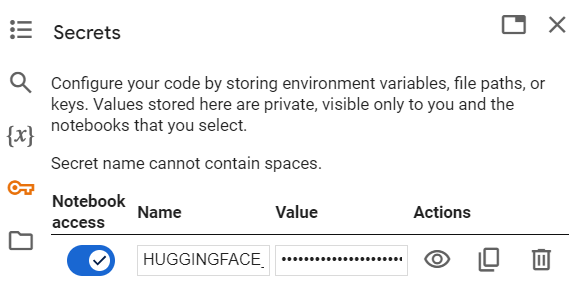

Login huggingface với access token trong secrets

In [ ]:
from google.colab import userdata
hf_token = userdata.get('HUGGINGFACE_TOKEN')
from huggingface_hub import login
login(token=hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Load Mistral-7B-Instruct-v0.3 với dtype bfloat16

In [ ]:
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM


model_path="mistralai/Mistral-7B-Instruct-v0.3"

tokenizer=AutoTokenizer.from_pretrained(model_path)

generator = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype = torch.bfloat16,
    device_map = "auto",
    trust_remote_code = True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Set padding token

In [ ]:
tokenizer.pad_token = tokenizer.unk_token
tokenizer.padding_side = "right"

Dùng apply_chat_template function để prompt model theo đúng format một cách dễ dàng.

Đọc thêm về chat template ở đây: https://huggingface.co/docs/transformers/main/en/chat_templating

In [ ]:
def simple_prompt(messages, tokenizer, model):
    model_inputs = tokenizer.apply_chat_template(messages,return_tensors = "pt")
#     print(model_inputs)

    model_inputs = model_inputs.to('cuda')

    generated_ids = model.generate(
        model_inputs,
        pad_token_id=tokenizer.pad_token_id,
        max_new_tokens = 1000,
        do_sample = True,
    )

    decoded = tokenizer.batch_decode(generated_ids)

#     print(decoded[0])
    return decoded[0]

Tạo một giao diện chat assistant đơn giản

In [ ]:
def simple_chat(tokenizer, model):
    user_input = None
    immediate_context = []
    while user_input != "bye": # end chat with bye message
        message = {"role": "user", "content": f"{user_input}"}

        if user_input == None:
            print('-'*103)
            user_input = input("| You |\n-------\n")
            continue
        immediate_context.append(message) # update chat history
#         print(immediate_context)

        res = simple_prompt(immediate_context, tokenizer, model)
#         print(res)

        answer = res.split('[/INST]')[-1].strip('</s>').strip()

        print('-'*103)
        padding = ' ' * 91
        el_id = 103
        print_answer = answer

        while len(print_answer) > el_id:
          print_answer = print_answer[:el_id] + '\n' + print_answer[el_id:]
          el_id += 103

        print(padding, " | Model |\n", padding, "---------\n", print_answer)

        response = {"role":"assistant", "content": f"{answer}"}
        immediate_context.append(response) # update chat history

        print('-'*103)
        user_input = input("| You |\n-------\n")
    print('-'*103)

In [ ]:
simple_chat(tokenizer, generator)

-------------------------------------------------------------------------------------------------------
| You |
-------
bye
-------------------------------------------------------------------------------------------------------


---

# Build RAG from scratch

In [ ]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 6.9 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
retriever = SentenceTransformer("all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
corpus_sentences = [
    "Barbenheimer was a cultural phenomenon which preceded and surrounded the simultaneous theatrical release of two films, Barbie and Oppenheimer, on July 21, 2023.",
    "The new movie is awesome",
    "The cat sits outside",
    "A man is playing guitar"
]

In [ ]:
corpus_embeddings = retriever.encode(corpus_sentences, show_progress_bar=True, convert_to_tensor=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import time
from sentence_transformers import util

In [ ]:
# Function that searches the corpus and prints the results
def search(inp_question):
    start_time = time.time()
    question_embedding = retriever.encode(inp_question, convert_to_tensor=True)
    hits = util.semantic_search(question_embedding, corpus_embeddings)
    end_time = time.time()
    hits = hits[0]  #Get the hits for the first query

    print("Input question:", inp_question)
    print("Results (after {:.3f} seconds):".format(end_time-start_time))
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['score'], corpus_sentences[hit['corpus_id']]))



In [ ]:
search("What's Barbenheimer?")

Input question: What's Barbenheimer?
Results (after 0.067 seconds):
	0.532	Barbenheimer was a cultural phenomenon which preceded and surrounded the simultaneous theatrical release of two films, Barbie and Oppenheimer, on July 21, 2023.
	0.128	The new movie is awesome
	-0.010	The cat sits outside
	-0.041	A man is playing guitar


In [ ]:
def return_context(inp_question):
    question_embedding = retriever.encode(inp_question, convert_to_tensor=True)
    hits = util.semantic_search(question_embedding, corpus_embeddings)
    hits = hits[0]  #Get the hits for the first query

    return corpus_sentences[hits[0]['corpus_id']]

In [ ]:
print(type(return_context("What's Barbenheimer?")))

<class 'str'>


In [ ]:
def rag_chat(tokenizer, model):
    user_input = None
    immediate_context = []
    print(user_input)
    while user_input != "bye": # end chat with bye message
        message = {"role": "user", "content": f"{user_input}\nContext: {return_context(str(user_input))}"}

        if user_input == None:
            print('-'*103)
            user_input = input("| You |\n-------\n")
            continue


        immediate_context.append(message) # update chat history
#         print(immediate_context)

        res = simple_prompt(immediate_context, tokenizer, model)
#         print(res)

        answer = res.split('[/INST]')[-1].strip('</s>').strip()

        print('-'*103)
        padding = ' ' * 91
        el_id = 103
        print_answer = answer

        while len(print_answer) > el_id:
          print_answer = print_answer[:el_id] + '\n' + print_answer[el_id:]
          el_id += 103

        print(padding, " | Model |\n", padding, "---------\n", print_answer)

        response = {"role":"assistant", "content": f"{answer}"}
        immediate_context.append(response) # update chat history

        print('-'*103)
        user_input = input("| You |\n-------\n")
    print('-'*103)

In [ ]:
rag_chat(tokenizer, generator)
# simple_chat(tokenizer, generator)

None
-------------------------------------------------------------------------------------------------------
| You |
-------
What's Barbenheimer?
-------------------------------------------------------------------------------------------------------
                                                                                             | Model |
                                                                                             ---------
 Barbenheimer seems to be a fictional term or phrase coined to describe a cultural phenomenon that occur
red in the year 2023, preceding and surrounding the simultaneous theatrical release of two films, "Bar
bie" and "Oppenheimer," on July 21, 2023. As this is a hypothetical scenario created by me for the pur
pose of answering your question, there is no specific or official definition for "Barbenheimer." The t
erm appears to be a blend of the characters Barbie and Oppenheimer, possibly referring to the intense 
interest, discussion, and a